CARNOT equation (ISO 9806) in SI units:
$$
\begin{equation}
    \begin{split}
        \dot m C_p \frac{(T_{out} - T_{in})}{A} & = F'\tau \alpha K_{dir} I_{dir} + F'\tau \alpha K_{dfu} I_{dfu} - c_1 (T_m - T_{amb}) \\
        & - c_2 (T_m - T_{amb})^2 - c_3 v_w (T_m - T_{amb}) - c_6 v_w I_{glb} \\
        & + c_4 (E_{longwave} - \sigma_{SB} T_{amb}^4) - c_5 \frac{dT_m}{dt}
    \end{split}
\end{equation}
$$

Substituting $T_{out} = 2T_m -Tin$ and solving for $\frac{dT_m}{dt}$ we get:

$$
\begin{equation}
    \begin{split}
         \frac{dT_m}{dt} & = \frac{1}{c_5} [F'\tau \alpha K_{dir} I_{dir} + F'\tau \alpha K_{dfu} I_{dfu} + F'\tau \alpha + c_1 (T_m - T_{amb}) \\
        & - c_2 (T_m - T_{amb})^2 - c_3 v_w (T_m - T_{amb}) - c_6 v_w I_{glb} \\
        & + c_4 (E_{longwave} - \sigma_{SB} T_{amb}^4) -2 \frac{\dot m C_p}{A} (T_{m} - T_{in})]
    \end{split}
\end{equation}
$$

For our test case, $I_{dfu} = c_3 = c_4 = c_6 = 0$:

$$
\begin{equation}
    \begin{split}
         \frac{dT_m}{dt} & = \frac{1}{c_5} [F'\tau \alpha K_{dir} I_{dir} - c_1 (T_m - T_{amb}) - c_2 (T_m - T_{amb})^2 -2 \frac{\dot m C_p}{A} (T_{m} - T_{in})]
    \end{split}
\end{equation}
$$

where $K_{dir} = K_b(L) \cdot K_b(T)$

Modified ISO equation:
$$
\begin{equation}
    \begin{split}
        \dot m C_p \frac{(T_{out} - T_{in})}{A} & = F'\tau \alpha K_{dir} I_{dir} + F'\tau \alpha K_{dfu} I_{dfu} - c_1 (T_m - T_{amb}) \\
        & - c_2 (T_m - T_{amb})^2 - c_3 v_w (T_m - T_{amb}) - c_6 v_w I_{glb} \\
        & + c_4 (E_{longwave} - \sigma_{SB} T_{amb}^4) - \frac{c_5}{2} \frac{dT_{out}}{dt}
    \end{split}
\end{equation}
$$

$$
\begin{equation}
    \begin{split}
         \frac{dT_{out}}{dt} & = \frac{2}{c_5} [F'\tau \alpha K_{dir} I_{dir} - c_1 (T_{out} +T_{in} 2T_{amb}) - c_2 (T_{out} +T_{in} 2T_{amb})^2 - \frac{\dot m C_p}{A} (T_{out} - T_{in})]
    \end{split}
\end{equation}
$$

In [75]:
# CARNOT parameters
t_0 = 20 + 273  # Initial temperature
area = 1           # surface  of one collector module in m2
F_ta = 0.507    # Fin Efficiency * Transmission * Absorption (F'(tau alfa))
c1 = 0.7153     # heat loss coefficient at (Tm-Ta)=0  [W/(m²*K)]
c2 = 0.00339    # temperature dependence of the heat loss coefficient [W/(m*K)²]
c3 = 0          # wind speed dependence of the heat loss coefficient [J/(m³K)]
c4 = 0          # sky temperature dependence of the heat loss coefficient [W/(m²K)]
c5 = 675        # effective thermal capacity [J/(m²K)]
c6 = 0          # wind dependence in the zero loss efficiency [s/m]
kb = [0, 10, 20, 30, 40, 50, 60, 70, 90]    # angles for longitudinal and transversal IAM [degree]
kbL = [1, 1, 1, 0.99, 0.98, 0.96, 0.93, 0.87, 0]    #values for longitudinal incidence angle modifier (0..1)
kbT = [1, 1.01, 1.04, 1.07, 1.09, 1.14, 1.22, 1.24, 0]  # values for transversal incidence angle modifier (0..1)
kd = 1  # Incidence angle modifier diffuse radiation

# my parameters
mdot = 80 / 3600    # mass flow rate (L/h to kg/s for water density=1000 kg/m3)
t_amb = 300         # ambient temperature
t_in = 290          # water inlet temperature
cp = 4200           # heat capacity (J/kg*k)

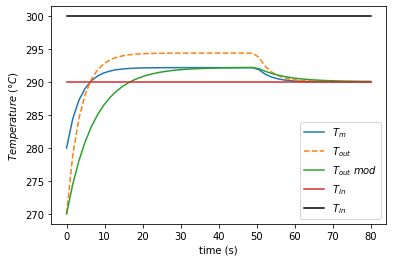

270.0


In [89]:
from splines import kdir
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np


def step_down(t, trigger_time):
    if t <= trigger_time:
        return 1
    return 0


def Idir(t):
    return step_down(t, 50)*800


idir_0 = 800


def iso_equation(Tm, t):
    dTmdt = (F_ta*kdir(0, 0)*Idir(t) - c1 * (Tm - t_amb) -
             c2 * (Tm - t_amb)**2 - 2 * mdot*cp*(Tm - t_in)/area)/c5
    return dTmdt


def iso_equation_modified(Tout, t):
    dToutdt = (F_ta*kdir(0, 0)*Idir(t) - c1 * (Tout + t_in-2*t_amb) -
               c2 * (Tout + t_in - 2*t_amb)**2 - 2 * mdot*cp*(Tout - t_in)/area)/2/c5
    return dToutdt


t = np.linspace(0, 80)
tm_0 = 280

tm = odeint(iso_equation, tm_0, t)
tout = 2*tm - t_in

tout_mod = odeint(iso_equation_modified, tout.min(), t)

t_in_arr = np.ones(len(t))*t_in
t_amb_arr = np.ones(len(t))*t_amb

plt.plot(t, tm, label="$T_m$")
plt.plot(t, tout, "--", label="$T_{out}$")
plt.plot(t, tout_mod,label="$T_{out} \ mod$")
plt.plot(t, t_in_arr, label="$T_{in}$")
plt.plot(t, t_amb_arr, "k", label="$T_{in}$")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("$Temperature \ (\degree C)$")
plt.show()
print(tout.min())